In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
img = cv2.imread('original.jpg', cv2.IMREAD_GRAYSCALE)

In [ ]:
img = np.hstack([np.zeros((img.shape[0], 1)), img, np.zeros((img.shape[0], 1))])
img = np.vstack([np.zeros((img.shape[1],)), img, np.zeros((img.shape[1],))])

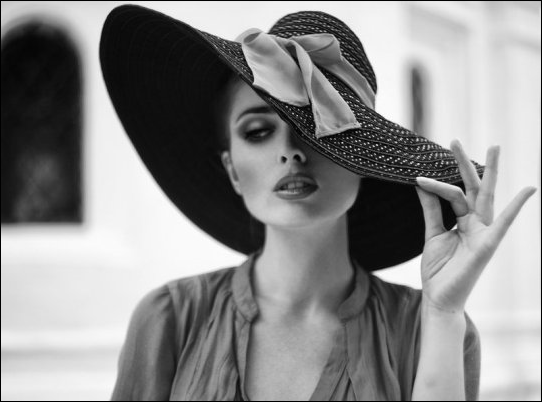

In [ ]:
cv2_imshow(img)

In [ ]:
mat = np.matrix(img)
with open('input.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%d')

In [ ]:
img.shape

(402, 542)

In [ ]:
%%writefile task.cu

#include <iostream>
#include <fstream>
#include <stdio.h>
using namespace std;

int* read(int rows, int cols) {
    int* matr = new int[rows*cols];

    ifstream myfile;
    myfile.open ("input.txt");

    for (int i = 0; i < rows*cols; ++i) {
        myfile >> matr[i];
    }
    return matr;
}

void write(int* matr, int rows, int cols) {
    ofstream file;
    file.open("output.txt");
    for (int i = 0; i < rows; i++)
    {
          for (int j = 0; j < cols; j++)
            {
              file<<matr[i*cols+j]<< ' ';
            }
      file<<"\n";
    }
	file.close();
}

//CUDA Kernels

// равномерное размытие
__global__
void ConvInit1(int* conv, int n, int m) {
    int x = threadIdx.x;
    int y = threadIdx.y;
    conv[m*y + x] = 1;

}

// интересная свёртка, но для 3х3
__global__
void ConvInit2(int* conv, int n, int m) {
    int x = threadIdx.x;
    int y = threadIdx.y;
    //conv[m*y + x] = 1;
    //for(int i=0; i < m*y + x; ++i)
      //conv[m*y + x] *= -1;
    if (m*y + x==4 || m*y + x==1 || m*y + x==7)
      conv[m*y + x] = 0;
    if (m*y + x==0 || m*y + x==3 || m*y + x==6)
      conv[m*y + x] = -1;
    if (m*y + x==2 || m*y + x==5 || m*y + x==8)
      conv[m*y + x] = 1;


}

__global__ 
void filter(int* img, int rows, int cols, int* conv, int n, int m, int* res) {
    
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    //printf("Hello world\n");
    if (x<rows-n+1 && y<cols-m+1) {
      int s = 0;
      int lin_coord = x*(cols - m + 1) + y;
      for(size_t i=0; i<n*m; ++i) {
          s += conv[i];
      }
      if (s==0)
        s = 1;
      res[lin_coord] = 0;
      
          for(int i=-n/2; i<=n/2; ++i) {
              for(int j=-m/2; j<=m/2; ++j) {                  
                  res[lin_coord] += conv[(i+n/2)*m+j+m/2] * img[(x+(n-1)/2 + i)*cols+y+(m-1)/2+j] / s;
                  //res[lin_coord] = 10;
          }
      }
    }
    
}


int main() {
    int rows = 402;
    int cols = 542;
    int* host_img = read(rows, cols);
    int* device_img;
    int* d_conv;
    int* h_res;
    int* d_res;
    cudaMalloc((void**)&device_img, rows*cols*sizeof(int));
    cudaMemcpy(device_img, host_img, rows*cols*sizeof(int), cudaMemcpyHostToDevice);

    cudaMalloc((void**)&d_conv, 3*3*sizeof(int));

    //ConvInit1<<<1, dim3(3,3)>>>(d_conv, 3, 3);
    ConvInit2<<<1, dim3(3,3)>>>(d_conv, 3, 3);
    cudaMalloc((void**)&d_res, (rows-2)*(cols-2)*sizeof(int));

    h_res = new int[(rows-2)*(cols-2)];

    filter<<<dim3(16,16), dim3(25, 34)>>>(device_img, rows, cols, d_conv, 3, 3, d_res);


    cudaMemcpy(h_res, d_res, (rows-2)*(cols-2)*sizeof(int), cudaMemcpyDeviceToHost);

    write(h_res, rows-2, cols-2);


    cudaFree(d_res);
    cudaFree(d_conv);
    cudaFree(device_img);
    delete h_res;
    delete[] host_img;
    //obliterate(img, rows, cols);
    return 0;
}

Writing task.cu


In [ ]:
!nvcc -arch sm_35 task.cu

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [ ]:
!./a.out

In [ ]:
with open('output.txt', 'r') as f:
    l = [[int(num) for num in line.split(' ')[:-1]] for line in f]


In [ ]:
img = np.array(l)

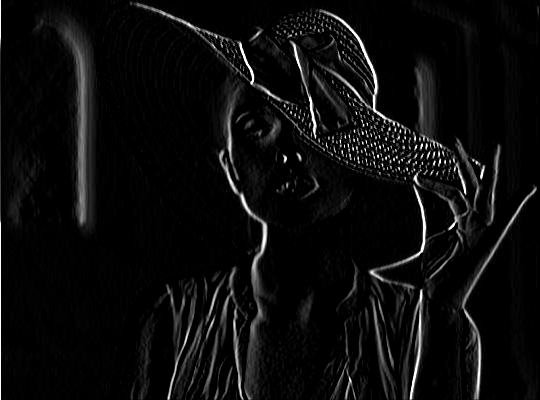

In [ ]:
cv2_imshow(img)